# Data

In [4]:
from skimage.graph import route_through_array
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os

path = '/home/parichay/MariGeoRoute/Genetic/Data/CMEMS/'
file = os.path.join(path,'mfwamglocep_2020120200_R20201203.nc')

data = xr.open_dataset(file)
data

/home/parichay/.local/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:    (longitude: 4320, latitude: 2041, time: 8)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude   (latitude) float64 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * time       (time) datetime64[ns] 2020-12-02T03:00:00 ... 2020-12-03
Data variables: (12/17)
    VHM0       (time, latitude, longitude) float32 ...
    VMDR_WW    (time, latitude, longitude) float32 ...
    VHM0_WW    (time, latitude, longitude) float32 ...
    VMDR_SW1   (time, latitude, longitude) float32 ...
    VTM01_SW1  (time, latitude, longitude) float32 ...
    VMDR_SW2   (time, latitude, longitude) float32 ...
    ...         ...
    VTPK       (time, latitude, longitude) float32 ...
    VSDX       (time, latitude, longitude) float32 ...
    VSDY       (time, latitude, longitude) float32 ...
    VPED       (time, latitude, longitude) float32 ...
    VTM02      (time, latitude, longitude) float32 ...
    VTM01_WW   (time, latitude, longitude) float32 ...
Attributes: (12/27)
    Conventions:                   CF-1.6
    time_coverage_start:           20201202-03:00:00
    time_coverage_end:             20201203-00:00:00
    date_created:                  20201203-06:35:00
    product_type:                  hindcast
    product:                       GLOBAL_ANALYSIS_FORECAST_WAV_001_027
    ...                            ...
    geospatial_lon_step:           0.08332825
    geospatial_lon_units:          degree
    geospatial_lat_min:            -80.0
    geospatial_lat_max:            90.0
    geospatial_lat_step:           0.08333588
    geospatial_lat_units:          degree

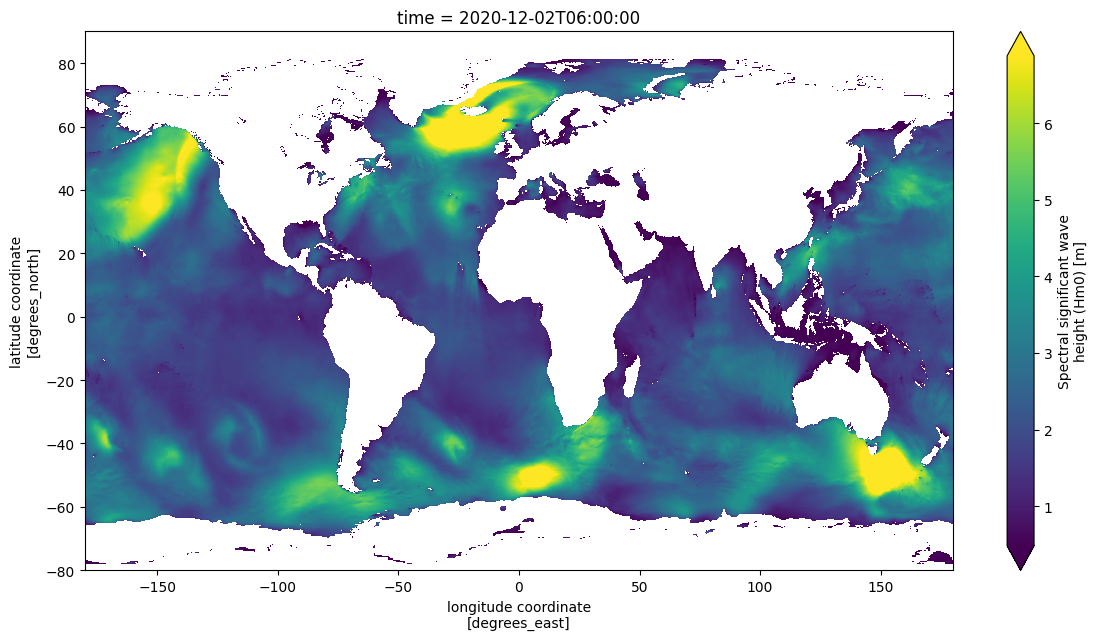

In [5]:
data.VHM0.isel(time=1).plot(robust=True, aspect=2, size=7);

In [6]:
# NY to Lisbon 
def get_closest(array, value):
    return np.abs(array - value).argmin()

bbox = ((-7.5, 60), (1, 40)) #((-80, 32),(-5, 47))
time_slice = 1
lon_min = get_closest(data.longitude.data,-17.5)#data.longitude.data, bbox[0][0])
lat_min = get_closest(data.latitude.data,42)#data.latitude.data, bbox[0][1])
lon_max = get_closest(data.longitude.data,2.5)#data.longitude.data, bbox[1][0])
lat_max = get_closest(data.latitude.data,52)#data.latitude.data, bbox[1][1])
# bounding box (latmin, lonmin, latmax, lonmax): 42, -17.5, 52, 2.5

lon_min, lat_min, lon_max, lat_max

(1950, 1464, 2190, 1584)

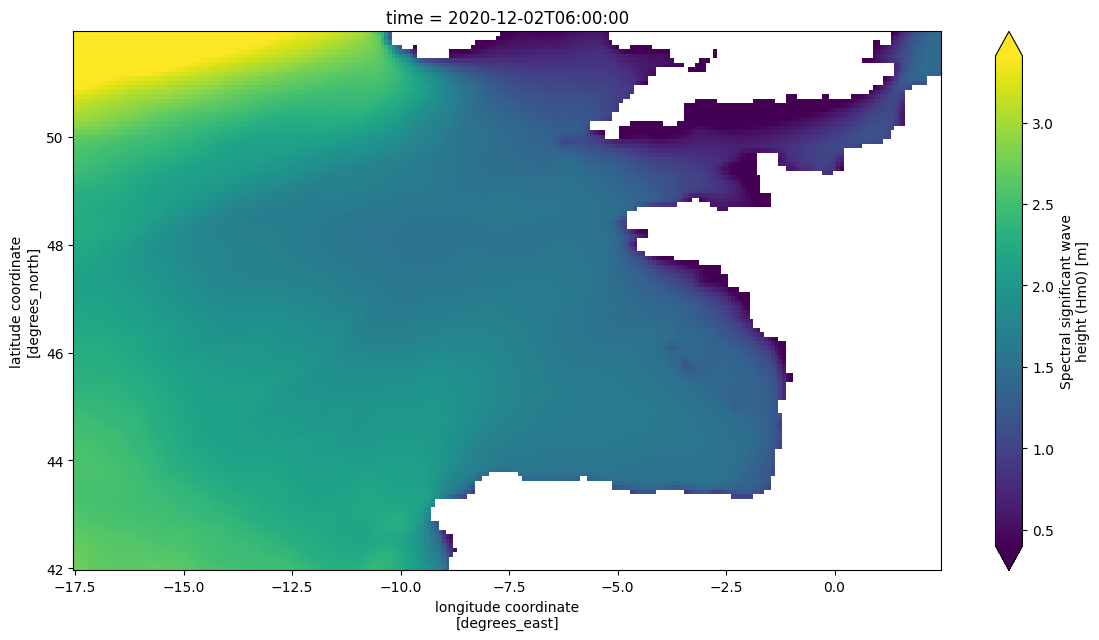

In [7]:
wave_height = data.VHM0.isel(time=time_slice, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))
wave_height.plot(robust=True, aspect=2, size=7);
plt.savefig('data.png')

plt.show()

In [8]:
cost = wave_height.data
cost = cost.copy()
#np.random.shuffle(cost)
nan_mask = np.isnan(cost)
cost[nan_mask] = 2* np.nanmax(cost) if np.nanmax(cost) else 0
wave_height.coords['longitude'][:]

<xarray.DataArray 'longitude' (longitude: 240)>
array([-17.5     , -17.416667, -17.333333, ...,   2.25    ,   2.333333,
         2.416667])
Coordinates:
  * longitude  (longitude) float64 -17.5 -17.42 -17.33 ... 2.25 2.333 2.417
    time       datetime64[ns] 2020-12-02T06:00:00
Attributes:
    standard_name:  longitude
    long_name:      longitude coordinate
    units:          degrees_east
    axis:           X
    step:           0.08332825

In [9]:
# Start coordinates: 51.121667, 1.355833; end coordinates: 45.490700, -1.491394 (Amsterdam -> Rotterdam -> Antwerpen -> Bordeaux)

lat_NY = 51.121667 #40.7128
lon_NY = 1.355833 #-74.0060
lat_LS = 45.490700 #38.7223
lon_LS = -1.491394  #-9.1393

start_lon = get_closest(wave_height.longitude.data, lon_NY)
start_lat = get_closest(wave_height.latitude.data, lat_NY)
end_lon = get_closest(wave_height.longitude.data,lon_LS)
end_lat = get_closest(wave_height.latitude.data,lat_LS)

start = (start_lat, start_lon)
end = (end_lat, end_lon)

print(start, end)

(109, 226) (42, 192)


<Figure size 1400x700 with 0 Axes>

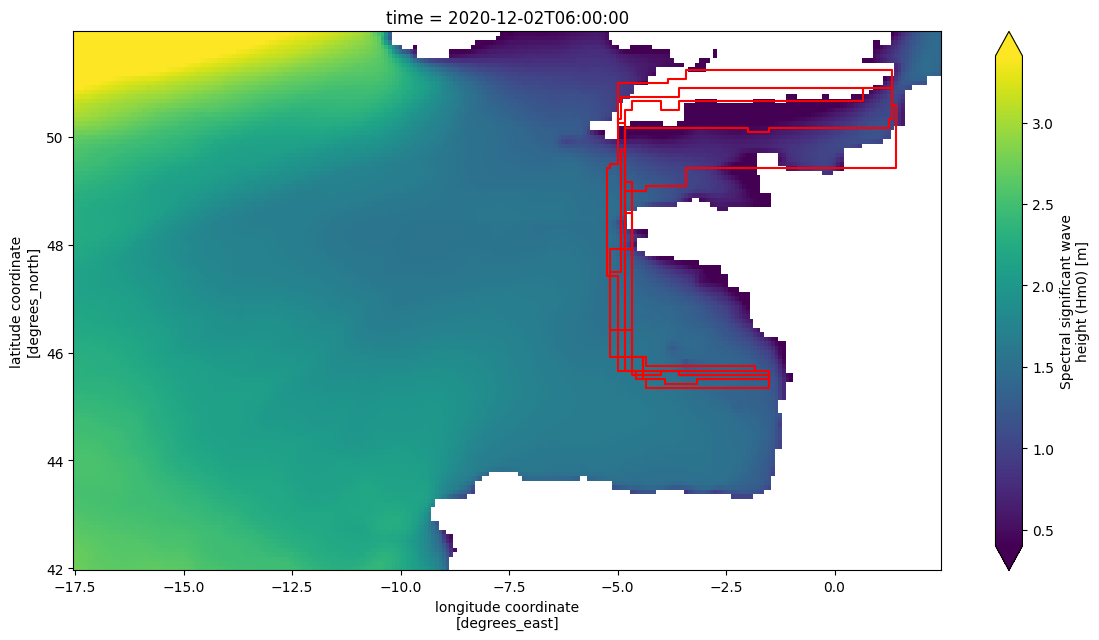

In [10]:
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
from skimage.graph import route_through_array
import random

# Generate n random routes
shuffled_cost = cost.copy()
#print(np.sum(shuffled_cost))
routes = []
n= 5
for i in range(n):
    shuffled_indices = np.random.permutation(len(shuffled_cost))
    shuffled_cost = shuffled_cost[shuffled_indices]
    route, _ = route_through_array(shuffled_cost,start, end, fully_connected=False, geometric=False)
    routes.append(route)
    
        
plt.figure(figsize=(14,7))
# Costs
#plt.imshow(cost, aspect='auto', vmin=np.min(cost), vmax=0.5*np.max(cost));
wave_height.plot(robust=True, aspect=2, size=7);
arr = np.zeros((5,1), dtype=object)
for i,route in enumerate (routes):
    arr[i][0] = route
    route = np.array(route)       
    plt.plot(wave_height.coords['longitude'][route[:, 1]], wave_height.coords['latitude'][route[:, 0]], "r-")
plt.plot(data.longitude.data[start[1]], data.latitude.data[start[0]], "go", markersize=10)
plt.plot(data.longitude.data[end[1]], data.latitude.data[end[0]], "ro", markersize=10)
plt.savefig('sampleroute.png')
plt.show()

# Constraints

In [11]:
import sys
import os

current_path = os.path.dirname(os.path.abspath(sys.argv[1]))
print(current_path)
sys.path.append(os.path.join(current_path, '..', ''))

from constraints.constraints import *

pars = ConstraintPars()
pars.resolution = 1./10

constraint_list = ConstraintsList(pars)

land_crossing = LandCrossing()
wave_height_const = WaveHeight()
constraint_list.add_neg_constraint(land_crossing)
constraint_list.add_neg_constraint(wave_height_const)

def is_neg_constraints(lat, lon, wh, time):  
    lat = np.array([lat])
    lon = np.array([lon])
    #print(lat,lon)

    wave_height_const.current_wave_height = np.array([wh])

    is_constrained = [False for i in range(0, lat.shape[0])]
    is_constrained = constraint_list.safe_endpoint(lat, lon, time, is_constrained)
    #print(is_constrained)
    return 1 if not is_constrained else 9999999

is_neg_constraints(52.7,4.04,11, 0)

/home/parichay/Mari/MariGeoRoute/Isochrone/algorithms


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


9999999

# Helper Functions

In [12]:
import numpy as np
import random
import math
import pymoo


# make initial population for genetic algorithm
def population(size, src, dest, cost):
    shuffled_cost = cost.copy()
    #print(shuffled_cost)
    #routes = []
    routes = np.zeros((size,1), dtype=object)
    for i in range(size):
        shuffled_indices = np.random.permutation(len(shuffled_cost))
        shuffled_cost = shuffled_cost[shuffled_indices]
        route, _ = route_through_array(shuffled_cost,src, dest, fully_connected=True, geometric=False)
        routes[i][0] = np.array(route)
    return routes

def crossOver(parent1, parent2):
    src = parent1[0]
    dest = parent1[-1]
    
    intersect = np.array([x for x in parent1 if any((x == y).all() for y in parent2)])

    if len(intersect) == 0:
        return parent1, parent2
    else:
        cross_over_point = random.choice(intersect)
        idx1 = np.where((parent1 == cross_over_point).all(axis=1))[0][0]
        idx2 = np.where((parent2 == cross_over_point).all(axis=1))[0][0]
        child1 = np.concatenate((parent1[:idx1], parent2[idx2:]), axis=0)
        child2 = np.concatenate((parent2[:idx2],parent1[idx1:]), axis=0)
        #print(child1, child2)
    return child1, child2

def route_cost(routes):
    costs = []
    #print(routes[0][0])
    for route in routes:
        costs.append(np.sum([cost[i,j] * is_neg_constraints(wave_height.coords['latitude'][i],
                                                          wave_height.coords['longitude'][j], cost[i,j], 0) for i,j in route[0]]))
    #print(costs)
    return costs
        

def mutate(route):
    source = route[0]
    destination = route[-1]

    path = route.copy()
    size = len(route)
    for i in range(1, size):
        end = random.randint(i+1,size-2)
        subpath, _ = route_through_array(cost,route[i-1], route[end+1], fully_connected=True, geometric=False)
        newPath = np.concatenate((route[:i-1],np.array(subpath),route[end+2:]), axis=0)
        #print(newPath)
        #if len(newPath) == len(set(newPath)):
        return newPath


# Define Custom Population Class

In [13]:
from pymoo.core.sampling import Sampling

class Population(Sampling):
    def __init__(self, src, dest, X,var_type=np.float64):
        super().__init__()
        self.var_type = var_type
        self.src = src
        self.dest = dest
        self.X = X
    def _do(self, problem, n_samples, **kwargs):
        routes = population(n_samples, self.src, self.dest, self.X)
        #print(routes.shape)
        self.X = routes
        #print(self.X.shape)
        return self.X

# Define Custom Crossover Class

In [14]:
from pymoo.core.crossover import Crossover

class Crossover1(Crossover):
    def __init__(self, prob=0.7):

        # define the crossover: number of parents and number of offsprings
        super().__init__(2, 2)
        self.prob = prob

    def _do(self, problem, X, **kwargs):

        # The input of has the following shape (n_parents, n_matings, n_var)
        _, n_matings, n_var = X.shape
        Y = np.full_like(X, None, dtype=object)
        for k in range(n_matings):
            # get the first and the second parent
            a, b = X[0, k, 0], X[1, k, 0]
            Y[0, k, 0], Y[1, k, 0] = crossOver(a,b)
        #print("Y:",Y)
        return Y

# Define Custom Mutation Class

In [15]:
from pymoo.core.mutation import Mutation

class Mutation1(Mutation):
    def __init__(self, prob =0.4):
        super().__init__()
        self.prob  = prob 

    def _do(self, problem, X, **kwargs):
        
        offsprings = np.zeros((2,1), dtype=object)
        # loop over individuals in population
        for idx,i in enumerate(X):
            # performe mutation with certain probability
            if np.random.uniform(0, 1) < self.prob:
                mutated_individual = mutate(i[0])
                #print("mutated_individual",mutated_individual, "###")
                offsprings[idx][0]=mutated_individual
        # if no mutation
            else:
                 offsprings[idx][0] =i[0]
        return offsprings

# Define The Routing Problem

In [16]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
import numpy as np
class RoutingProblem(Problem):
    def __init__(self):
        super().__init__(
            n_var=1, 
            n_obj=1, 
            n_constr=0)
    def _evaluate(self, X, out, *args, **kwargs):
        costs = route_cost(X)
        #print(costs.shape)
        out['F'] = np.column_stack([costs])
        
        

# Optimize

In [17]:
from pymoo.factory import get_termination
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX

pop_size = 2
n_gen = 300
n_offspring = 4
#cost[nan_mask] = 20000000000* np.nanmax(cost) if np.nanmax(cost) else 0
problem = RoutingProblem()
algorithm = NSGA2(pop_size=pop_size,
                  sampling= Population(start, end, cost),
                  crossover= Crossover1(),
                  n_offsprings = 2,
                  mutation= Mutation1(),
                  eliminate_duplicates=False)
termination = get_termination("n_gen", n_gen)

res = minimize(problem,
               algorithm,
               termination,
               save_history=True, 
               verbose=True)
#stop = timeit.default_timer()
#route_cost(res.X)

/tmp/ipykernel_115763/554111233.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  termination = get_termination("n_gen", n_gen)


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        2 |      1 |             - |             -
     2 |        4 |      1 |  1.762000E+08 |         ideal
     3 |        6 |      2 |  0.000000E+00 |             f
     4 |        8 |      2 |  0.000000E+00 |             f
     5 |       10 |      2 |  0.000000E+00 |             f
     6 |       12 |      2 |  0.000000E+00 |             f
     7 |       14 |      2 |  0.000000E+00 |             f
     8 |       16 |      2 |  0.000000E+00 |             f
     9 |       18 |      1 |  5.314299E+09 |         ideal
    10 |       20 |      2 |  0.000000E+00 |             f
    11 |       22 |      2 |  0.000000E+00 |             f
    12 |       24 |      2 |  0.000000E+00 |             f
    13 |       26 |      2 |  0.000000E+00 |             f
    14 |       28 |      2 |  0.000000E+00 |             f
    15 |       30 |      2 |  0.000000E+00 |             f
    16 |       32 |      2 |  0.000000E+00 |            

   137 |      274 |      2 |  0.000000E+00 |             f
   138 |      276 |      2 |  0.000000E+00 |             f
   139 |      278 |      2 |  0.000000E+00 |             f
   140 |      280 |      2 |  0.000000E+00 |             f
   141 |      282 |      2 |  0.000000E+00 |             f
   142 |      284 |      2 |  0.000000E+00 |             f
   143 |      286 |      2 |  0.000000E+00 |             f
   144 |      288 |      2 |  0.000000E+00 |             f
   145 |      290 |      2 |  0.000000E+00 |             f
   146 |      292 |      2 |  0.000000E+00 |             f
   147 |      294 |      2 |  0.000000E+00 |             f
   148 |      296 |      2 |  0.000000E+00 |             f
   149 |      298 |      2 |  0.000000E+00 |             f
   150 |      300 |      2 |  0.000000E+00 |             f
   151 |      302 |      2 |  0.000000E+00 |             f
   152 |      304 |      2 |  0.000000E+00 |             f
   153 |      306 |      2 |  0.000000E+00 |            

   276 |      552 |      2 |  0.000000E+00 |             f
   277 |      554 |      2 |  0.000000E+00 |             f
   278 |      556 |      2 |  0.000000E+00 |             f
   279 |      558 |      2 |  0.000000E+00 |             f
   280 |      560 |      2 |  0.000000E+00 |             f
   281 |      562 |      2 |  0.000000E+00 |             f
   282 |      564 |      2 |  0.000000E+00 |             f
   283 |      566 |      2 |  0.000000E+00 |             f
   284 |      568 |      2 |  0.000000E+00 |             f
   285 |      570 |      2 |  0.000000E+00 |             f
   286 |      572 |      2 |  0.000000E+00 |             f
   287 |      574 |      2 |  0.000000E+00 |             f
   288 |      576 |      2 |  0.000000E+00 |             f
   289 |      578 |      2 |  0.000000E+00 |             f
   290 |      580 |      2 |  0.000000E+00 |             f
   291 |      582 |      2 |  0.000000E+00 |             f
   292 |      584 |      2 |  0.000000E+00 |            

# Visualization

In [61]:
def index_to_coords(route):
    lats = wave_height.coords['latitude'][route[:,0]]
    lons = wave_height.coords['longitude'][route[:,1]]
    route = [[x,y] for x,y in zip(lats, lons)]
    return lats, lons,np.array(route)

In [62]:
# get the best solution
best_idx = res.F.argmin()
best_x = res.X[best_idx]
best_f = res.F[best_idx]
route=best_x[0]
index_to_coords(route)

(<xarray.DataArray 'latitude' (latitude: 136)>
 array([51.083333, 51.083333, 51.      , 50.916667, 50.916667, 50.916667,
        50.833333, 50.75    , 50.75    , 50.75    , 50.75    , 50.75    ,
        50.666667, 50.666667, 50.666667, 50.666667, 50.666667, 50.666667,
        50.75    , 50.75    , 50.666667, 50.666667, 50.666667, 50.666667,
        50.666667, 50.666667, 50.666667, 50.75    , 50.75    , 50.666667,
        50.583333, 50.583333, 50.583333, 50.666667, 50.666667, 50.666667,
        50.666667, 50.666667, 50.666667, 50.583333, 50.583333, 50.583333,
        50.583333, 50.583333, 50.583333, 50.583333, 50.583333, 50.583333,
        50.583333, 50.666667, 50.666667, 50.666667, 50.666667, 50.666667,
        50.583333, 50.5     , 50.416667, 50.333333, 50.25    , 50.166667,
        50.083333, 50.      , 49.916667, 49.833333, 49.75    , 49.666667,
        49.583333, 49.5     , 49.416667, 49.333333, 49.25    , 49.166667,
        49.083333, 49.      , 48.916667, 48.833333, 48.75    , 48

<Figure size 1400x700 with 0 Axes>

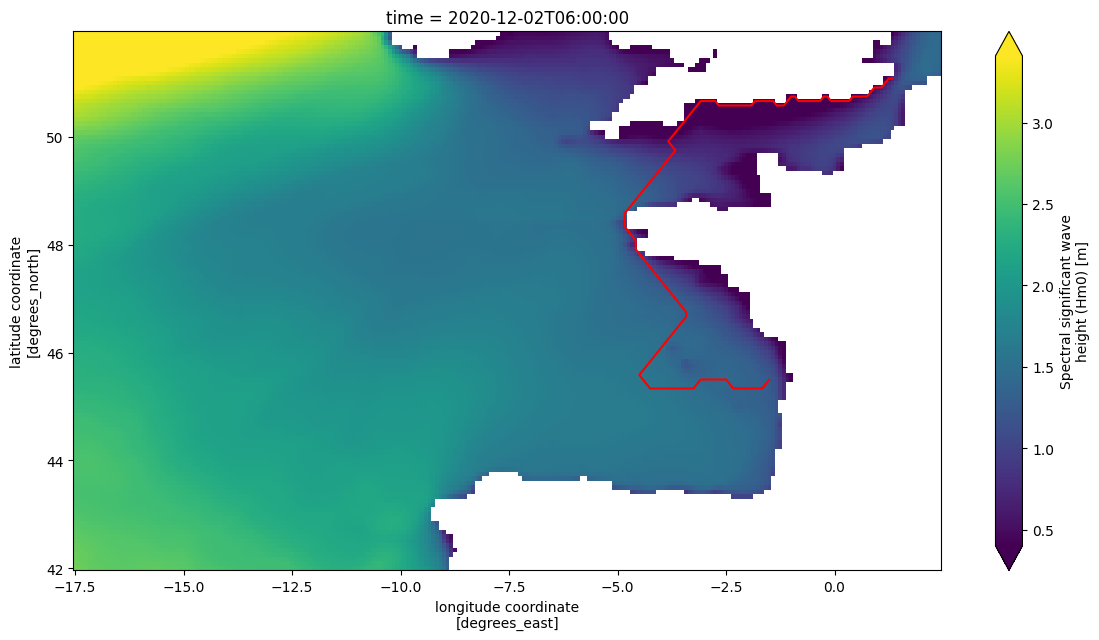

In [217]:
plt.figure(figsize=(14,7))
# Costs
#plt.imshow(cost, aspect='auto', vmin=np.min(cost), vmax=0.5*np.max(cost));
wave_height
wave_height.plot(robust=True, aspect=2, size=7);
plt.plot(wave_height.coords['longitude'][route[:, 1]], wave_height.coords['latitude'][route[:, 0]], "r-")
plt.plot(data.longitude.data[start[1]], data.latitude.data[start[0]], "go", markersize=10)
plt.plot(data.longitude.data[end[1]], data.latitude.data[end[0]], "ro", markersize=10)
plt.savefig('optimized_route.png')
plt.show()

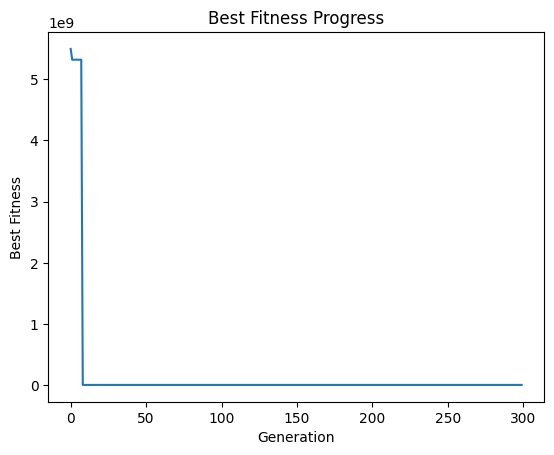

In [67]:
# Extract the best fitness values for each generation
best_fitness = [np.min(evaluator.pop.get("F")) for evaluator in res.history]

# Plot the best fitness values over generations
plt.plot(range(len(best_fitness)), best_fitness)
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Best Fitness Progress")
plt.show()

# Drafts

In [1]:
import pygame
# Define Pygame window size
WIDTH, HEIGHT = 800, 600

# Initialize Pygame
pygame.init()

# Create Pygame window
screen = pygame.display.set_mode((WIDTH, HEIGHT))

# Load map image
#map_img = pygame.image.load("map.png")

# Load ship image
ship_img = pygame.image.load("ship.png")

# Define function to plot optimized route and animate ship
def plot_route(route):
    # Scale coordinates to fit window size
    scaled_route = np.array(route) * np.array([WIDTH, HEIGHT])
    scaled_route = scaled_route.astype(int)
    
    # Set initial ship position to first point in route
    ship_pos = scaled_route[0]
    
    # Plot route and animate ship
    for point in scaled_route:
        # Draw line from previous point to current point
        pygame.draw.line(screen, (255, 0, 0), ship_pos, point, 5)
        
        # Update ship position
        ship_pos = point
        
        # Draw ship at current position
        screen.blit(ship_img, ship_pos - np.array([ship_img.get_width()/2, ship_img.get_height()/2]))
        
        # Update display and add delay for animation
        pygame.display.flip()
        pygame.time.delay(50)

# Plot optimized routes and animate ship
for solution in res.X:
    plot_route(np.array(solution))
    
# Wait for user to close window
while True:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
            sys.exit()

pygame 2.2.0 (SDL 2.0.22, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


NameError: name 'res' is not defined

In [499]:
import numpy as np

# create two 2D arrays
array1 = np.array([[1, 2], [3, 4], [5, 6]])
array2 = np.array([[2, 3], [4, 5], [6, 7]])

# find the intersecting points
intersect = np.intersect1d(array1, array2)

# print the intersecting points
print(intersect)


[2 3 4 5 6]


In [422]:
# find the indices of the intersecting points
intersect_indices = np.where(np.isin(array1, intersect))

# print the indices of the intersecting points
print(intersect_indices)

(array([0, 1, 1, 2, 2]), array([1, 0, 1, 0, 1]))


In [634]:
import numpy as np

# create two 2D arrays
array1 = np.array([[1, 2], [3, 4], [5, 6]])
array2 = np.array([[1, 2], [4, 5], [3, 4]])

# find the intersecting points where both elements match
intersect = np.array([x for x in array1 if any((x == y).all() for y in array2)])
choice = random.choice(intersect)
idx1 = np.where((array2 == choice).all(axis=1))[0][0]
print(choice, idx1)

# count the intersecting points
count = intersect.shape[0]

# print the count of the intersecting points
print(count)
intersect


[3 4] 2
2


array([[1, 2],
       [3, 4]])

In [445]:
intersect_indices

(array([], dtype=int64),)

In [446]:
intersect_indices = np.where(np.isin(array2_2nd, array1_2nd))

In [434]:
intersect_indices

(array([], dtype=int64),)

In [435]:
array1_2nd

array([2, 4, 6])

In [12]:
import sys
import os

current_path = os.path.dirname(os.path.abspath(sys.argv[1]))
print(current_path)
sys.path.append(os.path.join(current_path, '..', 'Isochrone'))

from Constraints import *

def is_neg_constraints(lat, lon, time):
    pars = ConstraintPars()
    pars.resolution = 1./10

    constraint_list = ConstraintsList(pars)

    land_crossing = LandCrossing()
    wave_height = WaveHeight()
    wave_height.current_wave_height = np.array([11])

    is_constrained = [False for i in range(0, lat.shape[0])]
    constraint_list.add_neg_constraint(land_crossing)
    constraint_list.add_neg_constraint(wave_height)
    is_constrained = constraint_list.safe_endpoint(lat, lon, time, is_constrained)
    return is_constrained

is_neg_constraints(np.array([52.7]),np.array([4.04]), 0)

/home/parichay/MariGeoRoute/Genetic


array([ True])

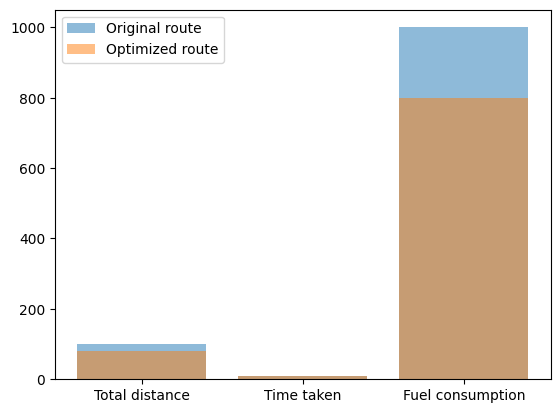

In [14]:
import matplotlib.pyplot as plt

# Define the metrics for each route
original_route_metrics = [100, 10, 1000]  # Total distance, time taken, fuel consumption
optimized_route_metrics = [80, 8, 800]

# Define the labels for each metric
metric_labels = ['Total distance', 'Time taken', 'Fuel consumption']

# Create a bar chart that compares the two routes
plt.bar(metric_labels, original_route_metrics, alpha=0.5, label='Original route')
plt.bar(metric_labels, optimized_route_metrics, alpha=0.5, label='Optimized route')
plt.legend()
plt.show()


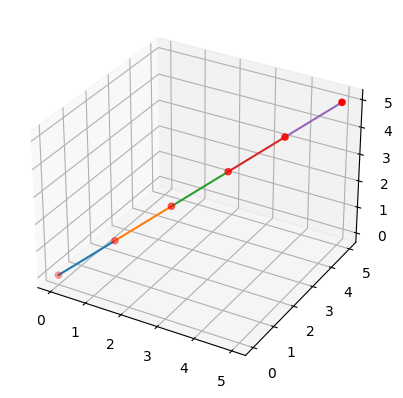

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the waypoints for the ship route
waypoints = np.array([[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4], [5, 5, 5]])

# Create a 3D scatter plot that shows the ship moving through the waypoints
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(waypoints[:, 0], waypoints[:, 1], waypoints[:, 2], c='r', marker='o')
for i in range(len(waypoints) - 1):
    ax.plot(waypoints[i:i+2, 0], waypoints[i:i+2, 1], waypoints[i:i+2, 2])
plt.show()


In [33]:
import mariPower

from geographiclib.geodesic import Geodesic

def calculate_route_courses(route):
   
    courses = [0]
    for i in range(len(route) - 1):
        lat1, lon1 = route[i]
        lat2, lon2 = route[i + 1]
        geod = Geodesic.WGS84.Inverse(lat1, lon1, lat2, lon2)
        course = geod['azi1']

        courses.append(course)

    return courses

print(routes)
courses = calculate_route_courses(route)
courses


[[(105, 72), (104, 72), (103, 72), (102, 72), (101, 72), (101, 73), (101, 74), (101, 75), (101, 76), (101, 77), (101, 78), (101, 79), (101, 80), (101, 81), (101, 82), (101, 83), (101, 84), (101, 85), (101, 86), (101, 87), (101, 88), (101, 89), (101, 90), (101, 91), (101, 92), (101, 93), (101, 94), (101, 95), (101, 96), (101, 97), (101, 98), (101, 99), (101, 100), (101, 101), (101, 102), (101, 103), (101, 104), (101, 105), (101, 106), (101, 107), (101, 108), (101, 109), (101, 110), (101, 111), (101, 112), (101, 113), (101, 114), (101, 115), (101, 116), (102, 116), (102, 117), (102, 118), (102, 119), (102, 120), (102, 121), (102, 122), (101, 122), (101, 123), (101, 124), (101, 125), (101, 126), (101, 127), (101, 128), (101, 129), (101, 130), (101, 131), (101, 132), (101, 133), (101, 134), (101, 135), (101, 136), (101, 137), (101, 138), (101, 139), (101, 140), (101, 141), (101, 142), (101, 143), (101, 144), (101, 145), (101, 146), (101, 147), (101, 148), (101, 149), (101, 150), (101, 151)

[0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,


In [16]:
import math
from ship.ship import Tanker

def calculate_course_for_route(route):
    courses = np.zeros(len(route)-1)
    lats = np.zeros(len(route)-1)
    lons = np.zeros(len(route)-1)
    
    for i in range(len(route) - 1):
        # Get the coordinates of the current and next waypoints
        lat1, lon1 = route[i]
        lats[i] = wave_height.coords['latitude'] [lat1]
        lons[i] = wave_height.coords['longitude'] [lon1]
        lat2, lon2 = route[i+1]
        
        # Convert latitude and longitude to radians
        lat1_rad = math.radians(lat1)
        lon1_rad = math.radians(lon1)
        lat2_rad = math.radians(lat2)
        lon2_rad = math.radians(lon2)
        
        # Calculate the course in radians
        delta_lon = lon2_rad - lon1_rad
        y = math.sin(delta_lon) * math.cos(lat2_rad)
        x = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon)
        course_rad = math.atan2(y, x)
        
        # Convert the course to degrees
        course_deg = math.degrees(course_rad)
        
        # Adjust the degrees to be in the range of 0-360
        course = (course_deg + 360) % 360
        
        # Append the course to the list
        courses[i] = course
    
    return courses, lats, lons
courses, lats, lons = calculate_course_for_route(route)
print(courses, lats, lons)

[344.55562672 343.66463751 342.78618329 196.26006125 269.52184658
 269.52184658 269.52184658 269.52184658 269.52184658 269.52184658
 342.78618329 269.52447059 269.52447059 269.52447059 269.52447059
 269.52447059 269.52447059 269.52447059 341.92071466 341.06864143
 269.53015229 269.53015229 340.23033313 269.53320826 269.53320826
 269.53320826 269.53320826 269.53320826 269.53320826 269.53320826
 269.53320826 269.53320826 339.40611966 338.5962922  269.53974579
 269.53974579 269.53974579 337.80110433 337.02077328 336.25548137
 202.84189473 269.54684405 269.54684405 269.54684405 269.54684405
 269.54684405 269.54684405 269.54684405 269.54684405 336.25548137
 202.84189473 202.06922683 269.54322535 269.54322535 269.54322535
 337.02077328 269.54684405 269.54684405 202.06922683 201.28179698
 200.47978966 199.66342417 198.8329561  197.98867852 197.13092316
 196.26006125 195.37650428 194.48070438 193.57315453 192.65438845
 191.72498016 190.78554326 189.83672983 188.87922902 187.91376526
 186.94109

In [17]:
tank = Tanker(2)
time = np.array(['2020.12.02']*len(courses))
tank.init_hydro_model_Route(file, '')
tank.get_fuel_per_time_netCDF(courses, lats, lons, time,cost)


Requesting power calculation
      Time:['2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02'
 '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02'
 '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02'
 '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02'
 '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02'
 '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02'
 '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02'
 '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02'
 '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02'
 '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02'
 '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02'
 '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02'
 '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02'
 '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02' '2020.12.02'
 '2020.12.02' '2020.12.02' '2020.12.

ValueError: cannot reshape array of size 778 into shape (68,1)